In [1]:
using LightGraphs, GraphPlot, Compose

In [110]:
m = 21;
x = linspace(-1,1,m); loc_x = repeat(x,inner = m);
y = linspace(-1,1,m); loc_y = repeat(y,outer = m);
Th = cos.(sqrt.(x.^2 .+ y'.^2) * pi/2);

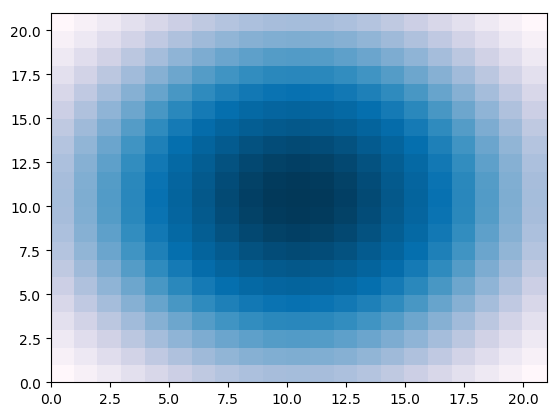

PyObject <matplotlib.collections.QuadMesh object at 0x143123b90>

In [111]:
pcolormesh(Th, cmap = "PuBu")

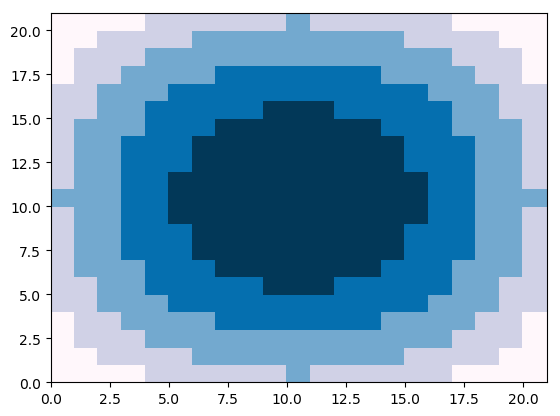

PyObject <matplotlib.collections.QuadMesh object at 0x14341aa10>

In [112]:
Theta = 3 * ceil.(3 * Th);
pcolormesh(Theta, cmap = "PuBu")

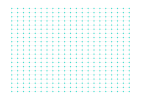

In [113]:
g = Grid([21;21]; periodic=false);
gplot(g,loc_x,loc_y)

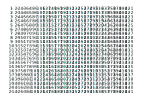

In [108]:
gplot(g,loc_x,loc_y, nodelabel = 1:441)

In [109]:
D = -full(incidence_matrix(g, oriented = true))'

840×441 Array{Int64,2}:
 1  -1   0   0   0   0   0   0  0  0  …   0   0   0   0   0   0   0   0   0
 1   0   0   0   0   0   0   0  0  0      0   0   0   0   0   0   0   0   0
 0   1  -1   0   0   0   0   0  0  0      0   0   0   0   0   0   0   0   0
 0   1   0   0   0   0   0   0  0  0      0   0   0   0   0   0   0   0   0
 0   0   1  -1   0   0   0   0  0  0      0   0   0   0   0   0   0   0   0
 0   0   1   0   0   0   0   0  0  0  …   0   0   0   0   0   0   0   0   0
 0   0   0   1  -1   0   0   0  0  0      0   0   0   0   0   0   0   0   0
 0   0   0   1   0   0   0   0  0  0      0   0   0   0   0   0   0   0   0
 0   0   0   0   1  -1   0   0  0  0      0   0   0   0   0   0   0   0   0
 0   0   0   0   1   0   0   0  0  0      0   0   0   0   0   0   0   0   0
 0   0   0   0   0   1  -1   0  0  0  …   0   0   0   0   0   0   0   0   0
 0   0   0   0   0   1   0   0  0  0      0   0   0   0   0   0   0   0   0
 0   0   0   0   0   0   1  -1  0  0      0   0   0   0   0   0 

In [114]:
theta = Theta[:];
n = length(theta);

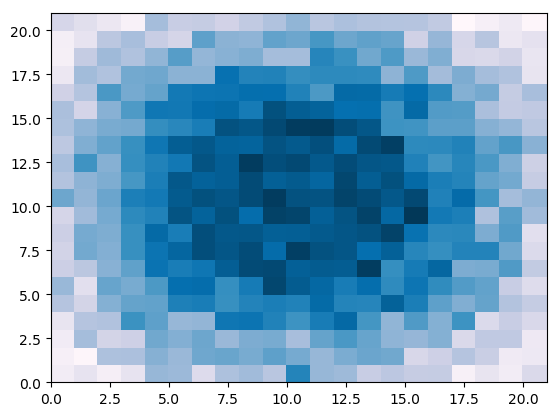

PyObject <matplotlib.collections.QuadMesh object at 0x143c02650>

In [120]:
sigma = 1.0;
y = theta + sigma * randn(n);
pcolormesh(reshape(y,m,m), cmap = "PuBu")

In [121]:
function change_point(y, D; v0 = 1e-1, v1 = 1e4, iter = 100)
    n = length(y);
    theta = y + 0.0 * randn(n);
    delta = D * theta;
    q = zeros(n);
    for i = 1:iter
        q = 1./( 1 + sqrt(v0/v1) * exp.(delta.^2/2 * (1/v0 - 1/v1)) );
        tau = q/v0 + (1-q)/v1;
        theta = (speye(n) + D'*Diagonal(tau)*D) \ y;
        delta = D * theta;
    end
    return theta, delta, q
end

change_point (generic function with 1 method)

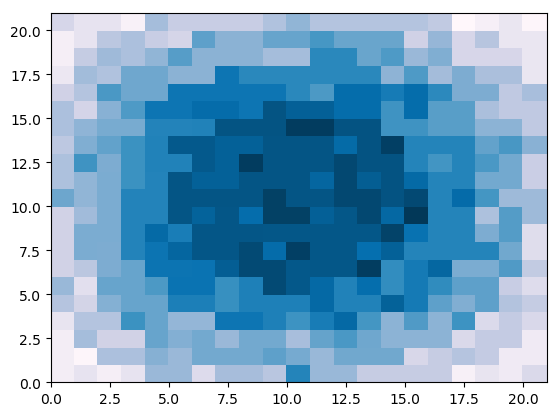

PyObject <matplotlib.collections.QuadMesh object at 0x110aad350>

In [128]:
out1 = change_point(y,D, v0 = 1e-2);
Theta_hat1 = reshape(out1[1],21,21);
pcolormesh(Theta_hat1, cmap = "PuBu")

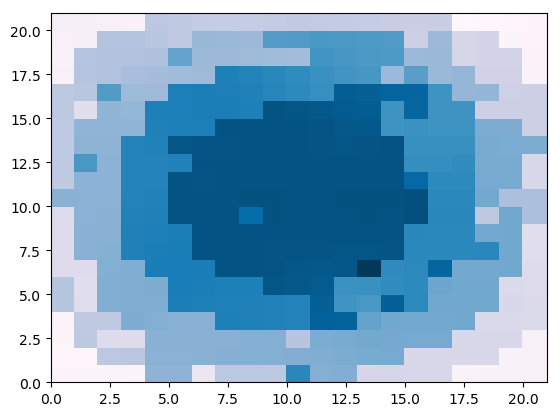

PyObject <matplotlib.collections.QuadMesh object at 0x1459a9890>

In [126]:
out = change_point(y,D);
Theta_hat = reshape(out[1],21,21);
pcolormesh(Theta_hat, cmap = "PuBu")

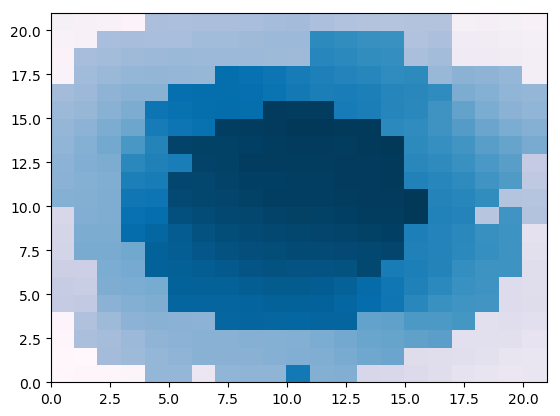

PyObject <matplotlib.collections.QuadMesh object at 0x12f5c40d0>

In [140]:
out2 = change_point(y,D, v0 = 1e-1*2);
Theta_hat2 = reshape(out2[1],21,21);
pcolormesh(Theta_hat2, cmap = "PuBu")

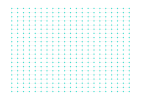

In [171]:
D = -full(incidence_matrix(g, oriented = true))'
ind = find(out2[3] .>= 0.5);
D_res = D[ind,:]
L_res = D_res'*D_res;
A = (abs.(L_res) - L_res)/2;
g2 = Graph(A);
gplot(g2,loc_x,loc_y)

In [178]:
function bayes_thresh(out, iter = 100)
    DD = -full(incidence_matrix(g, oriented = true))';
    ind = find(out[3] .>= 0.5);
    DD[ind,:] = 0;
    theta_sparse = out[1];
    for i = 1:iter
        theta_sparse = pinv(D) * D * theta_sparse + mean(y);
    end
    return reshape(theta_sparse,m,m)
end

bayes_thresh (generic function with 2 methods)

In [195]:
function model_selection(y,out)
    D_res = -full(incidence_matrix(g, oriented = true))';
    ind = find(out[3] .>= 0.5);
    D_res[ind,:] = 0;
    L_res = D_res'*D_res/v1;
    e_values = eig(L_res)[1];
    ind = find(e_values .> 1e-10);
    conn_comp = size(L_res,1) - length(ind);
    first_term = -sum(log.(e_values[ind]));
    second_term = sum(log.(1+e_values[ind]));
    third_term = sum((y-out[1]).^2);
    fourth_term = sum(out[2].^2);
    return first_term + second_term + third_term + fourth_term
end

model_selection (generic function with 1 method)

In [196]:
[model_selection(y,out1) model_selection(y,out) model_selection(y,out2)]

1×3 Array{Float64,2}:
 7239.28  5381.05  3981.46